In [63]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [64]:
# dataloader arguments
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = 'cpu'

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)


# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

print(len(train_loader), len(test_loader))

468 78


In [65]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 28*28

# Temporal Dynamics
num_steps = 25
beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        #print(torch.stack(spk2_rec, dim=0))

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [66]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    targets = targets.view(batch_size,-1).numpy()
    #_, idx = output.sum(dim=0).max(1)
    #_, idx = output.sum(dim=0).max(1)
    #acc = np.mean((targets == idx).detach().cpu().numpy())
    #print('op',output.shape, targets.shape)
    avg_rate_output = output.mean(axis=0).detach().numpy()
    acc = np.mean((avg_rate_output - targets)**2)

    #acc = np.mean((targets - idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc}")
    else:
        print(f"Test set accuracy for a single minibatch: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [67]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [69]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = data.view(batch_size, -1).to(device)

print(targets.shape, data.view(batch_size, -1).shape)

spk_rec, mem_rec = net(data.view(batch_size, -1))
print(spk_rec.size(), mem_rec.size())

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

torch.Size([128, 784]) torch.Size([128, 784])
torch.Size([25, 128, 784]) torch.Size([25, 128, 784])


In [70]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [71]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = data.to(device)#targets.to(device)
        targets = targets.squeeze(1)

        #print(targets.shape)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        #print(spk_rec.shape, mem_rec.shape, data.shape, targets.shape)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val = loss(spk_rec.mean(axis=0), targets.view(batch_size,-1))
        #for step in range(num_steps):
            #loss_val += loss(spk_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_data.to(device)#test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            test_loss = loss(test_spk.mean(axis=0), test_targets.view(batch_size,-1))
            #for step in range(num_steps):
                #test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 0.11
Test Set Loss: 0.11
Train set accuracy for a single minibatch: 0.11196702718734741
Test set accuracy for a single minibatch: 0.11020847409963608


Epoch 0, Iteration 50
Train Set Loss: 0.06
Test Set Loss: 0.07
Train set accuracy for a single minibatch: 0.0633135437965393
Test set accuracy for a single minibatch: 0.0656510442495346


Epoch 0, Iteration 100
Train Set Loss: 0.05
Test Set Loss: 0.05
Train set accuracy for a single minibatch: 0.0543651282787323
Test set accuracy for a single minibatch: 0.05338277295231819


Epoch 0, Iteration 150
Train Set Loss: 0.06
Test Set Loss: 0.06
Train set accuracy for a single minibatch: 0.055583205074071884
Test set accuracy for a single minibatch: 0.055462248623371124


Epoch 0, Iteration 200
Train Set Loss: 0.06
Test Set Loss: 0.05
Train set accuracy for a single minibatch: 0.05548733100295067
Test set accuracy for a single minibatch: 0.05298842117190361


Epoch 0, Iteration 250
Train Set Loss: 0.05
Test 

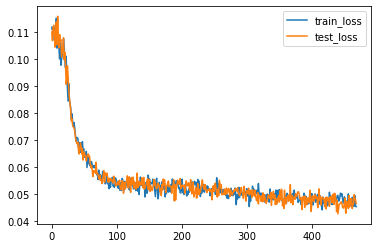

In [72]:
plt.figure()
plt.plot(loss_hist, label='train_loss')
plt.plot(test_loss_hist, label='test_loss')
plt.legend()

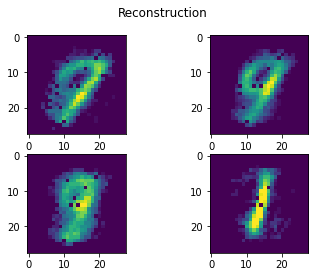

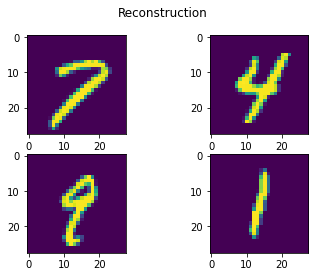

In [78]:
test_data, test_targets = next(iter(test_loader))

plt.figure()
for i in range(4):
    # Integrate through time for each location while displaying final image
    dat = test_data[i,:]
    spk_rec, mem_rec = net(dat.view(1, -1))
    final_image = spike_int = spk_rec.sum(0)[0].detach().numpy()
    #plt.figure()
    plt.subplot(2,2,i+1)
    plt.imshow(final_image.reshape((28, 28)))
    plt.suptitle('Reconstruction')
plt.show()

plt.figure()
for i in range(4):
    # Integrate through time for each location while displaying final image
    final_image = test_data[i,:].numpy()
    #plt.figure()
    plt.subplot(2,2,i+1)
    plt.imshow(final_image.reshape((28, 28)))
    plt.suptitle('Reconstruction')
plt.show()

    
